<a href="https://colab.research.google.com/github/UIT-19521183/CS114.L21/blob/UIT19522547-patch-1/Colab%20assignments/3)%20Predicting%20students'%20final%20exam%20scores%20from%20wecode%20data/predict_final_score1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BÀI TẬP COLAB SỐ 3:**
# **Predicting students' final exam scores from wecode data**



#Data preparation

In [ ]:
# Import các thư viện cần thiết
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [ ]:
# Đọc 2 files wecode.csv và score_training.csv lần lượt vào 2 biến Input và Output
Input=pd.read_csv("https://docs.google.com/spreadsheets/d/14LHQD-iaezhk6twpunNqZT7JFVMo5llTEkHeHqi0qs8/export?format=csv")
Output=pd.read_csv("https://docs.google.com/spreadsheets/d/129CHMLdJCJKhtE7kVN2EWsaJ7Q9cLYKYmNHHKBUQEYs/export?format=csv")

In [ ]:
Input

,id,assignment_id,problem_id,user_id,is_final,status,pre_score,coefficient,file_name,language_id,created_at,updated_at
0,4,0,3,4,1,SCORE,10000,100,solution-0,2,2020-10-30 10:58:11,2020-10-30 10:58:19
1,5,0,4,4,1,SCORE,10000,100,solution-1,2,2020-10-30 11:07:09,2020-10-30 11:07:17
2,6,0,5,4,0,Compilation Error,0,100,solution-2,2,2020-10-30 11:08:01,2020-10-30 11:23:36
3,7,0,5,4,0,Compilation Error,0,100,solution-3,2,2020-10-30 11:11:41,2020-10-30 11:11:42
4,8,0,5,4,0,Compilation Error,0,100,solution-4,2,2020-10-30 11:15:06,2020-10-30 11:15:07
...,...,...,...,...,...,...,...,...,...,...,...,...
264601,266667,0,25,1796,0,SCORE,0,100,solution-3977,4,2021-04-28 9:34:20,2021-04-28 9:34:27
264602,266668,0,25,1796,0,Compilation Error,0,100,solution-3978,2,2021-04-28 9:35:07,2021-04-28 9:35:08
264603,266669,0,25,1796,1,SCORE,10000,100,solution-3979,4,2021-04-28 9:35:15,2021-04-28 9:35:21
264604,266670,0,150,255,1,SCORE,6250,100,solution-3980,2,2021-05-11 1:34:57,2021-05-11 1:35:28


In [ ]:
Output

,id,QT,GK,TH,CK,TBM,TBTL
0,22,10,9,8.5,8.5,8.8,8.52
1,24,10,8,10,9.5,9.4,8.41
2,27,10,10,10,10,10,8.67
3,28,10,9.5,7.5,9.5,9.2,7.39
4,29,10,9.5,5,8.5,8.2,8.05
...,...,...,...,...,...,...,...
970,1857,5,4.5,10,4,6,6.03
971,1859,8,5,10,1.5,5.4,5.06
972,1862,5,6.5,1,7.5,5.1,4.71
973,1865,6.5,,3,7.5,,6.89


#Data discovery

**Danh sách các features cần thêm vào:**
1. Tổng số problem đã solved (is_final = 1 && pre_score=10000) / Tổng số problem có submit
2. Tổng số problem đã sumbit / Tổng số submissions
3. Số lần submit đúng (pre_score=10000) / tổng số submissions
4. Tổng pre_score của các submssion có is_final = 1 
...





## wecode.csv

In [ ]:
#Thông tin về file wecode.csv
Input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264606 entries, 0 to 264605
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             264606 non-null  int64 
 1   assignment_id  264606 non-null  int64 
 2   problem_id     264606 non-null  int64 
 3   user_id        264606 non-null  int64 
 4   is_final       264606 non-null  int64 
 5   status         264605 non-null  object
 6   pre_score      264606 non-null  int64 
 7   coefficient    264606 non-null  object
 8   file_name      264606 non-null  object
 9   language_id    264606 non-null  int64 
 10  created_at     264606 non-null  object
 11  updated_at     264606 non-null  object
dtypes: int64(7), object(5)
memory usage: 24.2+ MB




> **Nhận xét:** Tất cả các cột trong file wecode.csv đều đầy đủ giá trị, không có cột nào chứa null values 



In [ ]:
#file user_info chứa thông tin thống kê được của mỗi user_id dựa trên file wecode.csv
user_info=Input[["user_id", "id"]].groupby("user_id").count() #Đếm số lượng id(cũng là số lượng submissions của mỗi user)
user_info=user_info.rename(columns = {"id":"id_count"}).reset_index() #Đổi tên cột id vừa đếm thành id_count
user_info

,user_id,id_count
0,1,2
1,4,54
2,5,6
3,6,130
4,7,5
...,...,...
1154,1860,76
1155,1862,12
1156,1864,187
1157,1865,99


In [ ]:
# file assignment chứa thông tin về user_id và assignment_id
# drop những dòng trùng lặp nhau (giống nhau về cả user_id lẫn assignment_id)
assignment=Input[["user_id", "assignment_id"]].drop_duplicates() 
# Đếm số lượng asignment_id của mỗi user_id để thu thập thông tin số assignment mà mỗi sinh viên tham gia
assignment=assignment.groupby("user_id").count() 
assignment=assignment.rename(columns = {"assignment_id":"assignment_count"}).reset_index()
# Nối file user_id và thông tin về số assignment của mỗi sinh viên vừa tìm được ở trên
# (nối thẳng theo dòng tương ứng mà không cần join vì sau khi groupby user_id thì user_id đã được sort theo thứ tự)
user_info=pd.concat([user_info, assignment["assignment_count"]], axis=1) 
user_info

,user_id,id_count,assignment_count
0,1,2,1
1,4,54,1
2,5,6,4
3,6,130,4
4,7,5,1
...,...,...,...
1154,1860,76,10
1155,1862,12,2
1156,1864,187,5
1157,1865,99,3


In [ ]:
# Đếm số problems mà mỗi sinh viên tham gia và thêm vào file user_info giống như đếm số assignements
problem=Input[["user_id", "problem_id"]].drop_duplicates()
problem=problem.groupby("user_id").count()
problem=problem.rename(columns = {"problem_id":"problem_count"}).reset_index()
user_info=pd.concat([user_info, problem["problem_count"]], axis=1)
user_info

,user_id,id_count,assignment_count,problem_count,problem_count
0,1,2,1,2,2
1,4,54,1,41,41
2,5,6,4,5,5
3,6,130,4,88,88
4,7,5,1,2,2
...,...,...,...,...,...
1154,1860,76,10,43,43
1155,1862,12,2,6,6
1156,1864,187,5,63,63
1157,1865,99,3,17,17


In [ ]:
# file score chứa thông tin về user_id, assignment_id, problem_id, pre_score
score=Input[["user_id", "assignment_id", "problem_id", "pre_score"]]
# Nhóm các user_id, assignment_id, problem_id rồi tính tổng điểm mỗi user
score=score.groupby(["user_id","assignment_id", "problem_id"]).sum().apply(lambda x: x)
# Nhóm các user_id rồi tính điểm TB của mỗi user_id (= tổng điểm chia cho tổng số problems của tất cả assignments mà mỗi user_id tham gia) 
score=score.groupby(["user_id"]).mean()
score=score.rename(columns = {"pre_score":"average_score"}).reset_index()
# Thêm thông tin về điểm TB vừa tính vào file user_info
user_info=pd.concat([user_info, score["average_score"]], axis=1)
user_info

,user_id,id_count,assignment_count,problem_count,problem_count,average_score
0,1,2,1,2,2,5000.000000
1,4,54,1,41,41,11365.853659
2,5,6,4,5,5,6000.000000
3,6,130,4,88,88,10849.853933
4,7,5,1,2,2,9421.500000
...,...,...,...,...,...,...
1154,1860,76,10,43,43,8446.666667
1155,1862,12,2,6,6,6666.666667
1156,1864,187,5,63,63,8941.142857
1157,1865,99,3,17,17,11144.705882


In [ ]:
# Đếm số languages mà mỗi sinh viên tham gia và thêm vào file user_info giống như đếm số assignements
language=Input[["user_id", "language_id"]].drop_duplicates()
language=language.groupby("user_id").count()
language=language.rename(columns = {"language_id":"language_count"}).reset_index()
user_info=pd.concat([user_info, language["language_count"]], axis=1)
user_info

,user_id,id_count,assignment_count,problem_count,problem_count,average_score,language_count
0,1,2,1,2,2,5000.000000,1
1,4,54,1,41,41,11365.853659,1
2,5,6,4,5,5,6000.000000,1
3,6,130,4,88,88,10849.853933,1
4,7,5,1,2,2,9421.500000,1
...,...,...,...,...,...,...,...
1154,1860,76,10,43,43,8446.666667,1
1155,1862,12,2,6,6,6666.666667,1
1156,1864,187,5,63,63,8941.142857,1
1157,1865,99,3,17,17,11144.705882,1


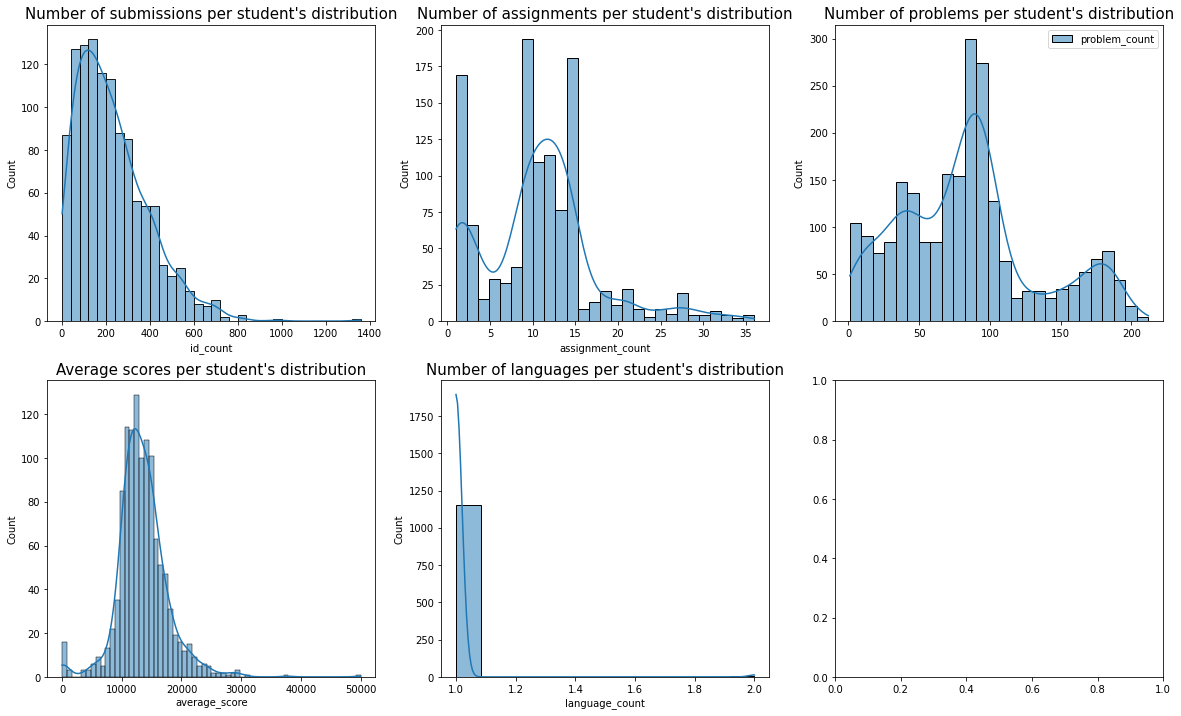

In [ ]:
cols=["id_count",	"assignment_count",	"problem_count",	"average_score",	"language_count"]
titles=["submissions","assignments","problems","Average scores", "languages"]
fig, axs = plt.subplots(2,3, figsize = (20,12))
n=0
for i in range(2):
  for j in range(3):
    if n!=5:
      if n!=3:
        axs[i,j].set_title("Number of "+titles[n]+" per student's distribution", size=15)
      else:
        axs[i,j].set_title(titles[n]+" per student's distribution", size=15)
      sns.histplot(user_info[cols[n]], kde=True, ax=axs[i,j])
      n+=1

In [ ]:
sum_user_done_problem = Input.loc[(Input['is_final'] == 1) & (Input['pre_score'] == 10000), ['user_id', 'problem_id', 'assignment_id']]\
                             .groupby(['assignment_id', 'problem_id'],  as_index=False)\
                             .count()
sum_user_done_problem

,assignment_id,problem_id,user_id
0,0,1,6
1,0,2,21
2,0,3,7
3,0,4,4
4,0,5,4
...,...,...,...
3152,383,318,25
3153,383,319,27
3154,384,626,33
3155,384,627,21


In [ ]:
Input.loc[(Input['is_final'] == 1) & (Input['pre_score'] == 10000), ['user_id', 'problem_id', 'assignment_id', 'coefficient']]\
     .

> **Nhận xét:**
*   Số submissions của các sinh viên rơi vào khoảng 40-240 là nhiều nhất
*   Số assignments của các sinh viên rơi vào khoảng 10-15 là nhiều nhất
*   Số problems của các sinh viên rơi vào khoảng 90-110 là nhiều nhất
*   Điểm wecode trung bình của các sinh viên rơi vào khoảng 10000-15000 là nhiều
*  Phần lớn sinh viên IT001 chỉ sử dụng 1 ngôn ngữ, việc sử dụng 2 ngôn ngữ là rất ít và có vẻ như là submit nhầm ngôn ngữ 

## score_training.csv

In [ ]:
Output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      975 non-null    int64 
 1   QT      973 non-null    object
 2   GK      974 non-null    object
 3   TH      974 non-null    object
 4   CK      974 non-null    object
 5   TBM     974 non-null    object
 6   TBTL    974 non-null    object
dtypes: int64(1), object(6)
memory usage: 53.4+ KB




> **Nhận xét:** Các cột trong file score_training.csv không đầy đủ giá trị. Các cột điểm đều có kiểu dữ liệu string chứ không phải float.



In [ ]:
cols=["QT",	"GK",	"TH",	"CK",	"TBM",	"TBTL"]
for col in cols:
  Output[col]=pd.to_numeric(Output[col],errors='coerce') # Chuyển từng cột điểm qua kiểu numeric 
Output

,id,QT,GK,TH,CK,TBM,TBTL
0,22,10.0,9.0,8.5,8.5,8.8,8.52
1,24,10.0,8.0,10.0,9.5,9.4,8.41
2,27,10.0,10.0,10.0,10.0,10.0,8.67
3,28,10.0,9.5,7.5,9.5,9.2,7.39
4,29,10.0,9.5,5.0,8.5,8.2,8.05
...,...,...,...,...,...,...,...
970,1857,5.0,4.5,10.0,4.0,6.0,6.03
971,1859,8.0,5.0,10.0,1.5,5.4,5.06
972,1862,5.0,6.5,1.0,7.5,5.1,4.71
973,1865,6.5,NaN,3.0,7.5,NaN,6.89


In [ ]:
Output=Output.dropna().rename(columns={"id":"user_id"})
Output

,user_id,QT,GK,TH,CK,TBM,TBTL
0,22,10.0,9.0,8.5,8.5,8.8,8.52
1,24,10.0,8.0,10.0,9.5,9.4,8.41
2,27,10.0,10.0,10.0,10.0,10.0,8.67
3,28,10.0,9.5,7.5,9.5,9.2,7.39
4,29,10.0,9.5,5.0,8.5,8.2,8.05
...,...,...,...,...,...,...,...
969,1856,5.0,5.5,7.0,7.5,6.7,7.34
970,1857,5.0,4.5,10.0,4.0,6.0,6.03
971,1859,8.0,5.0,10.0,1.5,5.4,5.06
972,1862,5.0,6.5,1.0,7.5,5.1,4.71


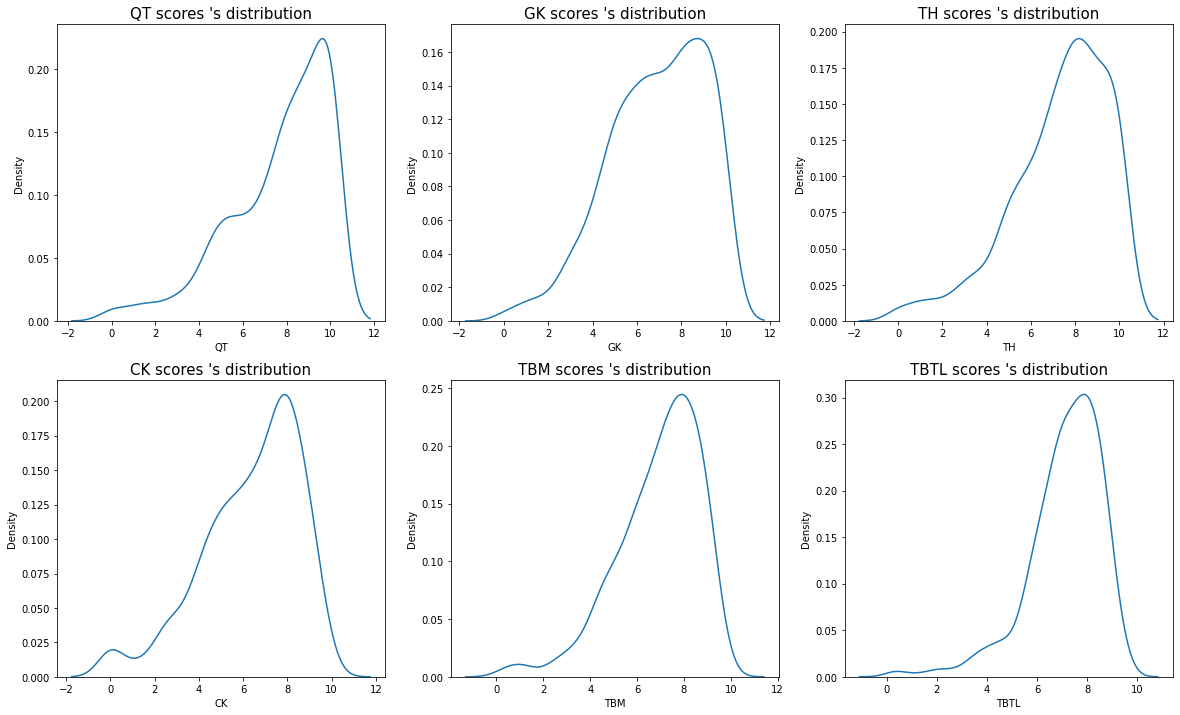

In [ ]:
cols=["id",	"QT",	"GK",	"TH",	"CK",	"TBM",	"TBTL"]
fig, axs = plt.subplots(2,3, figsize = (20,12))
n=1
for i in range(2):
  for j in range(3):
      axs[i,j].set_title(cols[n]+" scores 's distribution", size=15)
      sns.kdeplot(Output[cols[n]], ax=axs[i,j])
      n+=1



> **Nhận xét:** 
Điểm QT, GK và TH của các sinh viên rơi vào khoảng 8-10 là nhiều nhất. Nhưng điểm CK của các sinh viên thường chỉ rơi vào 8. Chính vì vậy, điểm TB môn của các sinh viên thường chỉ rơi vào 8 điểm do bị điểm CK kéo xuống.




## Joining 2 files (user_info and Output)

In [ ]:
training_data=user_info.merge(Output, on="user_id")
training_data

,user_id,id_count,assignment_count,problem_count,average_score,language_count,QT,GK,TH,CK,TBM,TBTL
0,24,164,15,78,13226.589744,1,10.0,8.0,10.0,9.5,9.4,8.41
1,27,13,2,5,10400.000000,1,10.0,10.0,10.0,10.0,10.0,8.67
2,29,199,13,80,15322.850000,1,10.0,9.5,5.0,8.5,8.2,8.05
3,35,297,25,147,11906.039474,1,7.0,9.5,6.0,4.5,6.2,5.75
4,37,312,12,102,15204.117647,1,5.5,5.5,7.5,7.5,6.9,8.27
...,...,...,...,...,...,...,...,...,...,...,...,...
677,1771,200,10,73,11132.480000,1,0.0,5.0,4.0,5.5,4.4,6.40
678,1856,64,5,31,10615.290323,1,5.0,5.5,7.0,7.5,6.7,7.34
679,1857,55,6,34,9725.000000,1,5.0,4.5,10.0,4.0,6.0,6.03
680,1859,31,7,27,1300.000000,1,8.0,5.0,10.0,1.5,5.4,5.06


In [ ]:
print("Number of rows in user_info:", user_info.shape[0])
print("Number of rows in Output:", Output.shape[0])
print("Number of rows in training_data:", training_data.shape[0])

Number of rows in user_info: 1159
Number of rows in Output: 785
Number of rows in training_data: 682




> **Nhận xét:**
* Số dòng của file user_info và Output trước khi join lần lượt là 1159 và 785
* Số dòng của file training_data sau khi join 2 files user_info và Output chỉ còn 682



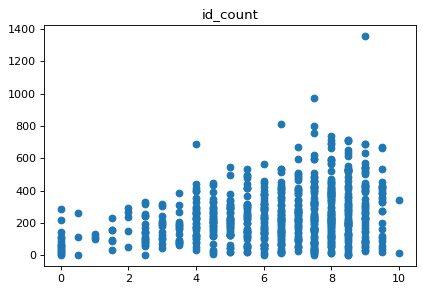

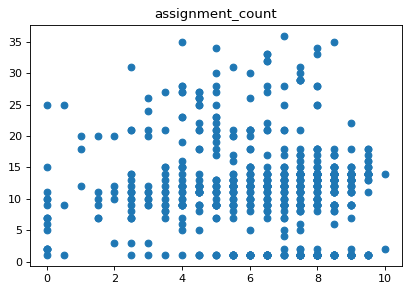

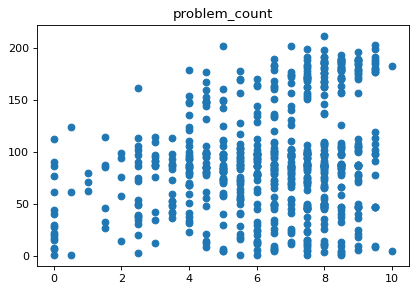

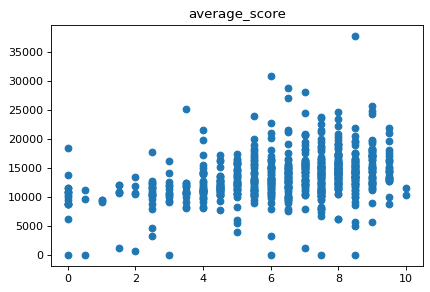

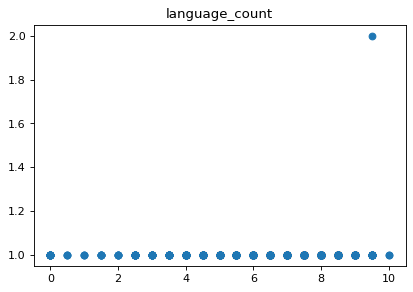

In [109]:
cols=["id_count",	"assignment_count",	"problem_count",	"average_score",	"language_count"]
for col in cols:
  plt.figure(dpi=80)
  plt.title(col)
  plt.scatter( training_data["CK"], training_data[col])
  plt.show() # Trục hoành là điểm cuối kì, trục tung là các features